# Football player appearance data analysis
### Data Engineering Capstone Project

#### Project Summary
Create a data warehouse analyzing football player appearances based on multiple source from `football_data_transfer_market` for European competitions. Either raw CSV datasets or a normalized JSON dataset.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

import etl

# Step 1: Scope the Project and Gather Data

#### Scope

Create analytics database for football player appearances in European competitions:

- Use spark to load the raw datasets.
- Explore the datasets for `player_appearances` and perform data cleaning.
- Read and create dimension tables from `games`, `clubs`, `competitions`, `player_appearances` datasets.
- Write fact and dimension tables to parquet files.
- Apply data quality checks on all table and raise error if a check failed.

## Gathering Data 
Reading data and describing it.

In [3]:
# Read in the data here

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV/JSON") \
    .master("local[*]") \
    .getOrCreate()
output_data = "output_data"

23/04/19 02:47:38 WARN Utils: Your hostname, exflqr43268 resolves to a loopback address: 127.0.1.1; using 192.168.0.215 instead (on interface wlp59s0)
23/04/19 02:47:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/19 02:47:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Player Appearances

This dataset is created from two datasets on Kaggle `Football Data from Transfermarkt`. https://www.kaggle.com/datasets/davidcariboo/player-scores

This JSON dataset consists of players information like names, birth, market value, game appearance, and some attributes. This dataset is written using `pyspark`, and it includes information from the two original datasets `players` and `player_appearances`.

In [4]:
# Save the data in JSON format
players_df = spark.read.json("raw_data/players_appearances/*")
players_df.show(5)

23/04/19 02:47:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-------------+-------+-------------+-------+--------------+------------------------+----------------+----------------------+------------------------------------+-----------------+--------------------+--------------------+-----------+----------+-----+-------+-----+------------+---------------------------+--------------------+------------+-----------+-------------------+------+--------------+------------------+--------------+------------------+----------------------+---------+------------+------------------+----------+---------+--------------+-------------+--------------------+------------+
|          agent_name|appearance_id|assists|city_of_birth|club_id|competition_id|contract_expiration_date|country_of_birth|country_of_citizenship|current_club_domestic_competition_id|current_club_name| 

### Games

This dataset is from Kaggle `Football Data from Transfermarkt`. https://www.kaggle.com/datasets/davidcariboo/player-scores

This provides 

In [5]:
games_df = etl.read_csv("football_data_transfer_market/games.csv", spark)
games_df.show(5)

+-------+--------------+----------------+------+------------------+-------------------+------------+------------+---------------+---------------+-------------------+------------------+------------------+-----------------+-----------------+----------------------+----------------------+--------------------+----------+--------------------+--------------------+
|game_id|competition_id|competition_type|season|             round|               date|home_club_id|away_club_id|home_club_goals|away_club_goals|          aggregate|home_club_position|away_club_position|   club_home_name|   club_away_name|home_club_manager_name|away_club_manager_name|             stadium|attendance|             referee|                 url|
+-------+--------------+----------------+------+------------------+-------------------+------------+------------+---------------+---------------+-------------------+------------------+------------------+-----------------+-----------------+----------------------+------------------

### Clubs

This dataset is from Kaggle `Football Data from Transfermarkt`. https://www.kaggle.com/datasets/davidcariboo/player-scores

In [6]:
clubs_df = etl.read_csv("football_data_transfer_market/clubs.csv", spark)
clubs_df.show(5)

+-------+------------------+------------------+-----------------------+------------------+----------+-----------+-----------------+---------------------+---------------------+--------------------+-------------+-------------------+----------------+--------------------+
|club_id|         club_code|              name|domestic_competition_id|total_market_value|squad_size|average_age|foreigners_number|foreigners_percentage|national_team_players|        stadium_name|stadium_seats|net_transfer_record|      coach_name|                 url|
+-------+------------------+------------------+-----------------------+------------------+----------+-----------+-----------------+---------------------+---------------------+--------------------+-------------+-------------------+----------------+--------------------+
|   1032|        fc-reading|        Fc Reading|                    GB1|             33.66|        26|       25.9|               12|                 46.2|                    6|Select Car Leasin.

### Competitions

This dataset is from Kaggle `Football Data from Transfermarkt`. https://www.kaggle.com/datasets/davidcariboo/player-scores

In [7]:
competitions_df = etl.read_csv("football_data_transfer_market/competitions.csv", spark)
competitions_df.show(5)

+--------------+----------------+---------------+---------------+------------------+----------+------------+----------------+-----------------+--------------------+-------------+--------------------+
|competition_id|competition_code|           name|           type|          sub_type|country_id|country_name|country_latitude|country_longitude|domestic_league_code|confederation|                 url|
+--------------+----------------+---------------+---------------+------------------+----------+------------+----------------+-----------------+--------------------+-------------+--------------------+
|            L1|      bundesliga|     Bundesliga|domestic_league|        first_tier|        40|     Germany|      51.1638175|       10.4478313|                  L1|       europa|https://www.trans...|
|           DFB|       dfb-pokal|      Dfb Pokal|   domestic_cup|      domestic_cup|        40|     Germany|      51.1638175|       10.4478313|                  L1|       europa|https://www.trans...|


In [8]:
print(f"Number of `player_appearances` JSON rows: {players_df.count():,}")
print(f"Number of rows from CSV data sources: {games_df.count()+clubs_df.count()+competitions_df.count():,}")

Number of `player_appearances` JSON rows: 1,079,339
Number of rows from CSV data sources: 61,641


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

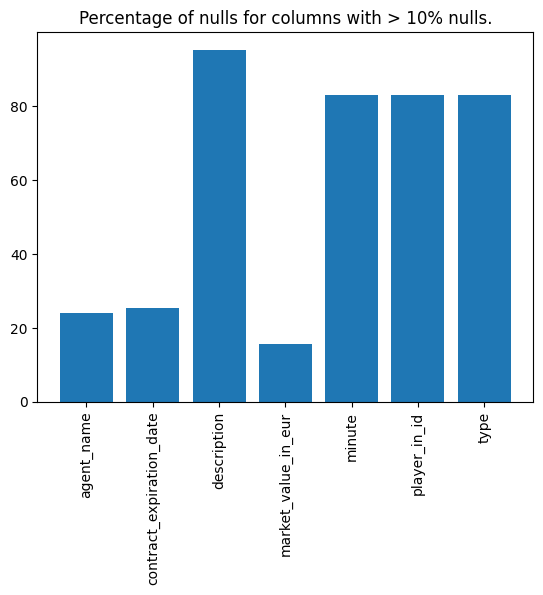

In [9]:
etl.inspect_data(players_df, perc=10, preview=True)

The graph shows the columns with more than 10% missing values. `description` has around 95% missing values, next are `minute`, `player_in_id`, and `type` with around 82% missing values. There are some missing values for columns like `appearance_id` and `competition_id` which is missing for the plot as it has less than 10% of missing values.

In [10]:
# While inspecting the data a deformity in column values was recognized.
# As it can be seen in the shown table below the name was not added correctly for the `first_name` and `last_name` columns.

players_df.select(
    "player_id",
    "name",
    "first_name",
    "last_name",
    "club_id"
).where(col("last_name")=="Mohamed Salah").show(5)

+---------+-------------+----------+-------------+-------+
|player_id|         name|first_name|    last_name|club_id|
+---------+-------------+----------+-------------+-------+
|   148455|Mohamed Salah|      null|Mohamed Salah|     31|
|   148455|Mohamed Salah|      null|Mohamed Salah|     31|
|   148455|Mohamed Salah|      null|Mohamed Salah|     31|
|   148455|Mohamed Salah|      null|Mohamed Salah|     31|
|   148455|Mohamed Salah|      null|Mohamed Salah|     31|
+---------+-------------+----------+-------------+-------+
only showing top 5 rows



#### Cleaning Steps
Document steps necessary to clean the data

In [11]:
# Here we fix the namings by splitting the name to the first_name and last_name,
# if one of them have null values.
players_df = etl.fix_names(players_df)
players_df.select(
    "player_id",
    "name",
    "first_name",
    "last_name",
    "club_id"
).where(col("last_name")=="Salah").show(5)

+---------+-------------+----------+---------+-------+
|player_id|         name|first_name|last_name|club_id|
+---------+-------------+----------+---------+-------+
|   148455|Mohamed Salah|   Mohamed|    Salah|     31|
|   148455|Mohamed Salah|   Mohamed|    Salah|     31|
|   148455|Mohamed Salah|   Mohamed|    Salah|     31|
|   148455|Mohamed Salah|   Mohamed|    Salah|     31|
|   148455|Mohamed Salah|   Mohamed|    Salah|     31|
+---------+-------------+----------+---------+-------+
only showing top 5 rows



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

![Conceptual Data Model](data_model.png)

The fact table is made up from the JSON raw dataset `players_appearances`. This fact table consists of the appearance attributes for players in every minute of the game.

The needed dimensions for this model are:
- players: for details related to the player origin, position, and age.
- games: for details related to the place of the game, managers, clubs, and goals.
- competitions: to track the main competition for every game a table with the competitions details is needed.
- countries: This table has only the countries with competitions included in our data model.
- time: for a more detailed time attributes, this table splits the appearance dates into more dimensions of interest.

All the dimensions tables are collected from CSV datasets from football_data_transfer_market original data. Except for players and time tables, which are similar to player_appearance table are collected from the JSON raw data files.

All dimension table link to the fact `player_appearance` table through the date and different primary IDs in every dimension.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

- Load the raw datasets.
- Investigate the players_appearances raw dataset.
- Applying some cleaning for the players_appearances raw dataset.
- Create dimensions tables: [players, games, clubs, competitions, countries, time]
- Create fact table: player_appearance.
- Apply data quality checks over dimension and fact table.

In [12]:
import etl
time = etl.create_time_table(players_df, output_data)

In [13]:
players = etl.create_players_table(players_df, output_data)
time = etl.create_time_table(players_df, output_data)
player_appearance = etl.create_player_appearance_table(players_df, output_data)
games = etl.create_games_table(games_df, output_data)
clubs = etl.create_clubs_table(clubs_df, output_data)
competitions = etl.create_competitions_table(competitions_df, output_data)
countries = etl.create_countries_table(competitions_df, output_data)

23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/04/19 02:49:28 WARN MemoryManager: Total allocation exceeds 95.

23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/04/19 02:50:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


23/04/19 02:55:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


23/04/19 02:59:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/04/19 03:00:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

- The pipeline can run by running etl.py. It should be possible to run it as a spark script using `spark-submit etl.py `

#### 4.2 Data Quality Checks
 
Run Quality Checks:

1- Data availability by checking that all data frames exists.

2- Table data completeness and no missing rows for any table. 

In [14]:
dimension_tables = {
    "players": players,
    "time": time,
    "games": games,
    "clubs": clubs,
    "competitions": competitions,
    "countries": countries,
}
etl.data_quality_check(dimension_tables)

player_appearance = {"player_appearance": player_appearance}
etl.data_quality_check(player_appearance)

Table players exists.


Table players has 27,456 rows.
Table time exists.


Table time has 2,315 rows.
Table games exists.
Table games has 61,197 rows.
Table clubs exists.
Table clubs has 401 rows.
Table competitions exists.
Table competitions has 43 rows.
Table countries exists.
Table countries has 15 rows.
Table player_appearance exists.


Table player_appearance has 1,079,339 rows.


"Data quality check passed for ['player_appearance']"

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

Dimension `players` data dictionary:

In [15]:
# Players
pd.DataFrame(
        {
            'Column name': ['player_id', 'birth_date', 'birth_country', 'citizenship', 'first_name', 'last_name', 'height', 'foot', 'position', 'sub_position'],
            'Type': ['LongType()', 'StringType()', 'StringType()', 'StringType()', 'StringType()', 'StringType()', 'LongType()', 'StringType()', 'StringType()', 'StringType()'],
            'Description': [
                'Football player unique ID',
                'The date of player birth',
                'The country of birth',
                'The player\'s citizenship',
                'First Name', 'Last Name', 'Height in CM',
                'Preferred Foot', 'The main playing position',
                'The second playing position']
        })

,Column name,Type,Description
0,player_id,LongType(),Football player unique ID
1,birth_date,StringType(),The date of player birth
2,birth_country,StringType(),The country of birth
3,citizenship,StringType(),The player's citizenship
4,first_name,StringType(),First Name
5,last_name,StringType(),Last Name
6,height,LongType(),Height in CM
7,foot,StringType(),Preferred Foot
8,position,StringType(),The main playing position
9,sub_position,StringType(),The second playing position


Dimension `time` data dictionary:

In [16]:
# Players
pd.DataFrame(
        {
            'Column name': [
                'date', 'hour', 'day', 'week', 'month', 'year', 'weekday'],
            'Type': [
                'StringType()', 'IntegerType()', 'IntegerType()', 
                'IntegerType()', 'IntegerType()', 'IntegerType()', 'IntegerType()'],
            'Description': [
                'Timestamp for each recorded appearance',
                'Appearance in hours',
                'Appearances in days',
                'Appearances in weeks',
                'Appearances in month',
                'Appearances in year',
                'Appearances in weekday',
                ]
        })

,Column name,Type,Description
0,date,StringType(),Timestamp for each recorded appearance
1,hour,IntegerType(),Appearance in hours
2,day,IntegerType(),Appearances in days
3,week,IntegerType(),Appearances in weeks
4,month,IntegerType(),Appearances in month
5,year,IntegerType(),Appearances in year
6,weekday,IntegerType(),Appearances in weekday


Dimension `Games` data dictionary:

In [17]:
# Games
pd.DataFrame(
        {
            'Column name': [
                    'game_id', 'home_club_id', 'away_club_id',
                    'home_club_goals', 'away_club_goals', 'home_club_position',
                    'away_club_position', 'home_club_manager', 'away_club_manager',
                    'stadium', 'attendance', 'referee'
                    ],
            'Type': [
                    'IntegerType()', 'IntegerType()', 'IntegerType()',
                    'IntegerType()', 'IntegerType()', 'IntegerType()',
                    'IntegerType()', 'StringType()', 'StringType()',
                    'StringType()', 'IntegerType()', 'StringType()'
                    ],
            'Description': [
                'Game unique ID',
                'The playing home club unique ID',
                'The playing away club unique ID',
                'Number of goals for the host club',
                'Number of goals for the guest club',
                'The competition position for the host',
                'The competition position for the guest',
                'Home club manager',
                'Away club manager',
                'Stadium name',
                'Number of attendance',
                'Game referee name.'
                ]
        }
)

,Column name,Type,Description
0,game_id,IntegerType(),Game unique ID
1,home_club_id,IntegerType(),The playing home club unique ID
2,away_club_id,IntegerType(),The playing away club unique ID
3,home_club_goals,IntegerType(),Number of goals for the host club
4,away_club_goals,IntegerType(),Number of goals for the guest club
5,home_club_position,IntegerType(),The competition position for the host
6,away_club_position,IntegerType(),The competition position for the guest
7,home_club_manager,StringType(),Home club manager
8,away_club_manager,StringType(),Away club manager
9,stadium,StringType(),Stadium name


Dimension `Clubs` data dictionary:

In [18]:
# Clubs
pd.DataFrame(
        {
            'Column name': [
                    'club_id', 'name', 'squad_size', 'average_age',
                    'foreigners_percentage', 'national_team_players',
                    'stadium_name', 'stadium_seats', 'coach_name'],
            'Type': [
                    'IntegerType()', 'StringType()', 'IntegerType()',
                    'DoubleType()', 'DoubleType()', 'IntegerType()',
                    'StringType()', 'IntegerType()', 'StringType()'
                    ],
            'Description': [
                'Club unique ID',
                'Club name',
                'Football quad size',
                'Squad average age',
                'Foreigners players percentage',
                'National team players percentage',
                'Stadium name',
                'stadium available seats',
                'Coach name',
                ]
        }
)

,Column name,Type,Description
0,club_id,IntegerType(),Club unique ID
1,name,StringType(),Club name
2,squad_size,IntegerType(),Football quad size
3,average_age,DoubleType(),Squad average age
4,foreigners_percentage,DoubleType(),Foreigners players percentage
5,national_team_players,IntegerType(),National team players percentage
6,stadium_name,StringType(),Stadium name
7,stadium_seats,IntegerType(),stadium available seats
8,coach_name,StringType(),Coach name


Dimension `Competitions` data dictionary:

In [19]:
# Competitions
pd.DataFrame(
        {
            'Column name': ['competition_id', 'name', 'type', 'country_id'],
            'Type': ['StringType()', 'StringType()', 'StringType()', 'IntegerType()'],
            'Description': [
                'Competition unique ID',
                'Competition name',
                'Competition type',
                'Country unique ID where the competition is played',
                ]
        }
)

,Column name,Type,Description
0,competition_id,StringType(),Competition unique ID
1,name,StringType(),Competition name
2,type,StringType(),Competition type
3,country_id,IntegerType(),Country unique ID where the competition is played


Dimension `Countries` data dictionary:

In [20]:
# Countries
pd.DataFrame(
        {
            'Column name': ['country_id', 'country_name', 'country_latitude', 'country_longitude'],
            'Type': ['IntegerType()', 'StringType()', 'DoubleType()', 'DoubleType()'],
            'Description': [
                'Country unique ID',
                'Country name',
                'Country latitude',
                'Country longitude',
                ]
        }
)

,Column name,Type,Description
0,country_id,IntegerType(),Country unique ID
1,country_name,StringType(),Country name
2,country_latitude,DoubleType(),Country latitude
3,country_longitude,DoubleType(),Country longitude


Fact `Player Appearance` data dictionary :

In [21]:
# Player Appearance
pd.DataFrame(
        {
            'Column name': [
                    'appearance_id', 'player_id', 'competition_id',
                    'game_id', 'club_id', 'yellow_cards', 'red_cards',
                    'minute', 'minutes_played', 'goals', 'assists', 'date'
                    ],
            'Type': [
                    'StringType()', 'LongType()', 'StringType()', 'LongType()',
                    'LongType()', 'LongType()', 'LongType()', 'LongType()',
                    'LongType()', 'LongType()', 'LongType()', 'StringType()'
                    ],
            'Description': [
                    'Player appearance unique ID',
                    'Player unique ID', 'Competition unique ID',
                    'Game unique ID', 'Club unique ID',
                    'Number of given yellow cards to the player',
                    'Number of given red cards to the player',
                    'The appearance minute in game',
                    'Number of minutes played',
                    'Number of goals by the player',
                    'Number of assist by the player',
                    'Timestamp for the appearance',
                    ]
        }
)

,Column name,Type,Description
0,appearance_id,StringType(),Player appearance unique ID
1,player_id,LongType(),Player unique ID
2,competition_id,StringType(),Competition unique ID
3,game_id,LongType(),Game unique ID
4,club_id,LongType(),Club unique ID
5,yellow_cards,LongType(),Number of given yellow cards to the player
6,red_cards,LongType(),Number of given red cards to the player
7,minute,LongType(),The appearance minute in game
8,minutes_played,LongType(),Number of minutes played
9,goals,LongType(),Number of goals by the player


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

* Choice of tools and technologies for the project:
  - Dataset: The `football_data_transfer_market` dataset was chosen for its freshness, size, and source credibility.
  - Spark: It was used for speed by performing in-memory computations, scalability when the data size increase we can increase number of used clusters, flexibility in python and task versatility with large datasets.

* Propose how often the data should be updated and why.
  - Main source of data is at [Kaggle](https://www.kaggle.com/datasets/davidcariboo/player-scores) is updated weekly. Hence, weekly update is proposed.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
    - As we are already using spark, we are able to scale our pipeline by increasing the number of partitions and size of Spark cluster, optimize the data pipeline by tuning Spark configuration parameters, use distributed file system like Hadoop or Amazon S3 to distribute data across multiple nodes.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
    - Optimize data extraction.
    - Use efficient data storage, The used parquet should already help in this as it can provide fast access to the data.
    - Airflow can be very helpful in orchestrating and scheduling the data pipeline.
    - Monitoring and alerting to identify issues and errors before they become critical. Tools like Nagios can help.
 * The database needed to be accessed by 100+ people.
    - Make sure database can handle increased number of users and their queries by scaling up hardware resources.
    - Consider using distributed architecture for example using distributed file system like Hadoop to handle large datasets and provide fault tolerance.
    - Redshift can be good solution as it handle large amounts of data and provide fast query performance.
    - Monitor and optimize the pipeline regularly using Apache Spark monitoring